In [4]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, Model, preprocessing
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D

In [5]:
random_seed = 42
np.random.seed(random_seed)

In [6]:
train_data_dir = './data_split/train'
test_data_dir = './data_split/test'

img_size = (224, 224)
batch_size = 32

train_ds = preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.3,
    subset='training',
    seed=random_seed,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True, 
    crop_to_aspect_ratio=True
)

val_ds = preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.3,
    subset='validation',
    seed=random_seed,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True, 
    crop_to_aspect_ratio=True
)

test_ds = preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    crop_to_aspect_ratio=True
)

class_names = train_ds.class_names

#train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
#test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

Found 1545 files belonging to 3 classes.
Using 1082 files for training.
Found 1545 files belonging to 3 classes.
Using 463 files for validation.
Found 517 files belonging to 3 classes.


### Evaluation methods

In [5]:
def predict_test_data(model, test_data):
    true_labels = []
    pred_labels = []
    
    for images, labels in test_data:
        preds = model.predict(images)
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
        pred_labels.extend(np.argmax(preds, axis=1))
    return true_labels, pred_labels

In [6]:
def make_classification_report(true_labels, pred_labels):
    print(classification_report(true_labels, pred_labels, target_names=class_names))

In [7]:
def make_confusion_matrix(true_labels, pred_labels):
    m = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(m, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [10]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

### Base model

Our base model is a plain ResNet50 model which is initialized with random weights and therefore has no prior knowledge of any images.

In [11]:
# Build model from scratch (random init)
base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=len(class_names)) # include_top=True adds the classification layer

base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.8767 - loss: 1.8777 - val_accuracy: 0.9071 - val_loss: 81.0777
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8867 - loss: 0.4708 - val_accuracy: 0.8898 - val_loss: 6.0373
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9079 - loss: 0.3615 - val_accuracy: 0.8121 - val_loss: 2.0796
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9122 - loss: 0.3330 - val_accuracy: 0.7819 - val_loss: 1.0377
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 315s 8s/step - accuracy: 0.9123 - loss: 0.3046 - val_accuracy: 0.9071 - val_loss: 0.3274
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - accuracy: 0.9070 - loss: 0.3056 - val_accuracy: 0.8834 - val_loss: 0.4309
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 278s 8s/step - accuracy: 0.9118 - loss: 0.2988 - val_accuracy: 0.9071 - val_loss: 0.6162
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - accuracy: 0.8987 - loss: 0.3195 - val_accuracy: 0.7732 - va

In [13]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


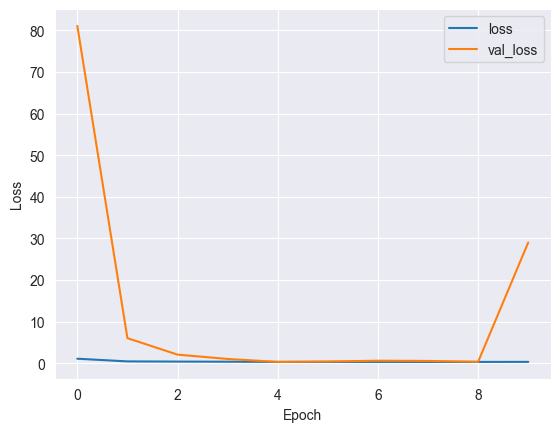

In [14]:
plot_loss(history)

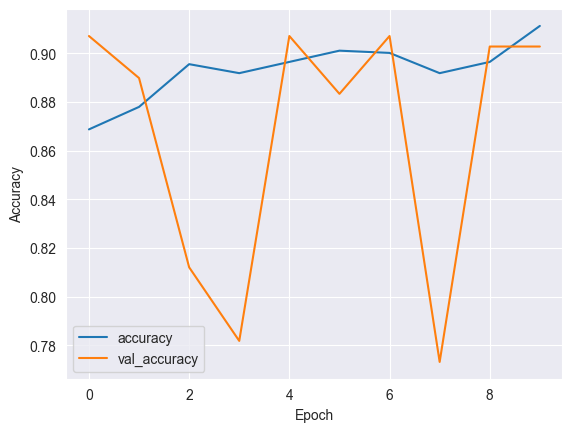

In [15]:
plot_accuracy(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

         Ant       0.00      0.00      0.00        37
        Bear       0.00      0.00      0.00        17
         Bee       0.90      1.00      0.94       463

    accuracy                           0.90       517
   macro avg       0.30      0.33      0.31       517
weighted avg       0.80      0.90      0.85       517



C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Clemens\anaconda3\envs\CV_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

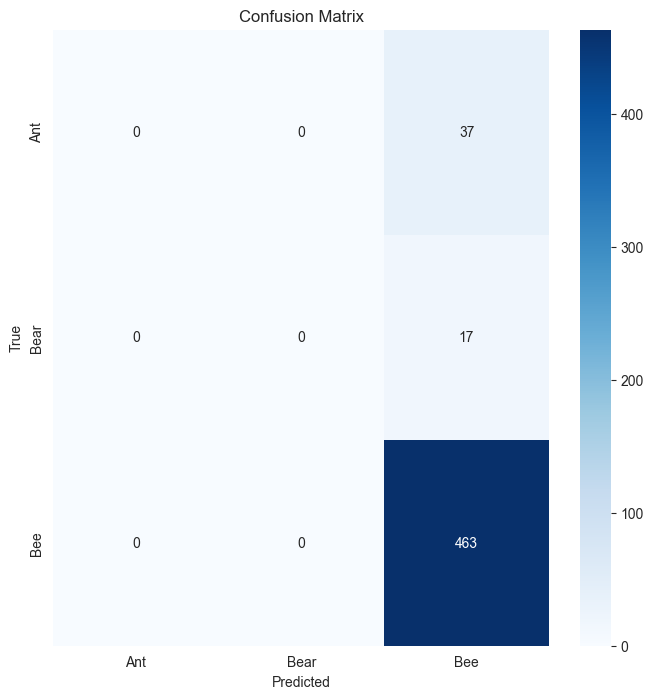

In [16]:
y_true, y_pred = predict_test_data(base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

In [18]:
base_model.save('./models/PlainResNet50.keras')

## Pretrained model

Use the weights that were obtained by training on the imagenet dataset. All other parameters stay the same to really compare two models.

In [19]:
def build_pretrained_model():
    base_architecture = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), classes=len(class_names), pooling='avg') # pooling None, avg or max?
    
    base_architecture.trainable = False # no need to re-train these layers
    
    model = tf.keras.models.Sequential()
    model.add(base_architecture)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


pretrained_model = build_pretrained_model()
pretrained_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
pretrained_history = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 # train until converging? accuracy is already good
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 795ms/step - accuracy: 0.8448 - loss: 0.9275 - val_accuracy: 0.9849 - val_loss: 0.0388
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 736ms/step - accuracy: 0.9824 - loss: 0.0556 - val_accuracy: 0.9870 - val_loss: 0.0401
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 738ms/step - accuracy: 0.9913 - loss: 0.0262 - val_accuracy: 0.9827 - val_loss: 0.0383
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 736ms/step - accuracy: 0.9964 - loss: 0.0109 - val_accuracy: 0.9870 - val_loss: 0.0347
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 738ms/step - accuracy: 0.9963 - loss: 0.0096 - val_accuracy: 0.9914 - val_loss: 0.0334
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9892 - val_loss: 0.0316
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 738ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9892 - val_loss: 0.0317
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 738ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accu

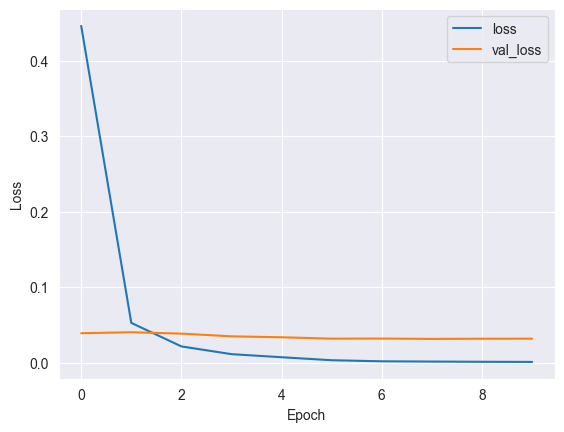

In [21]:
plot_loss(pretrained_history)

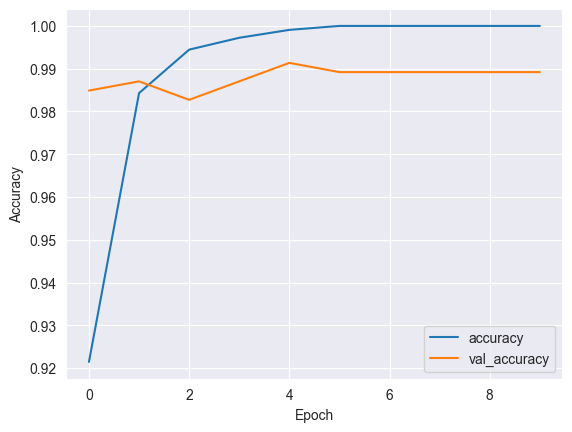

In [22]:
plot_accuracy(pretrained_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
              precision    recall  f1-score   support

         Ant       0.97      0.84      0.90        37
        Bear       1.00      0.94      0.97        17
         Bee       0.99      1.00      0.99       463

    accuracy                           0.98       517
   macro avg       0.98      0.93      0.95       517
weighted avg  

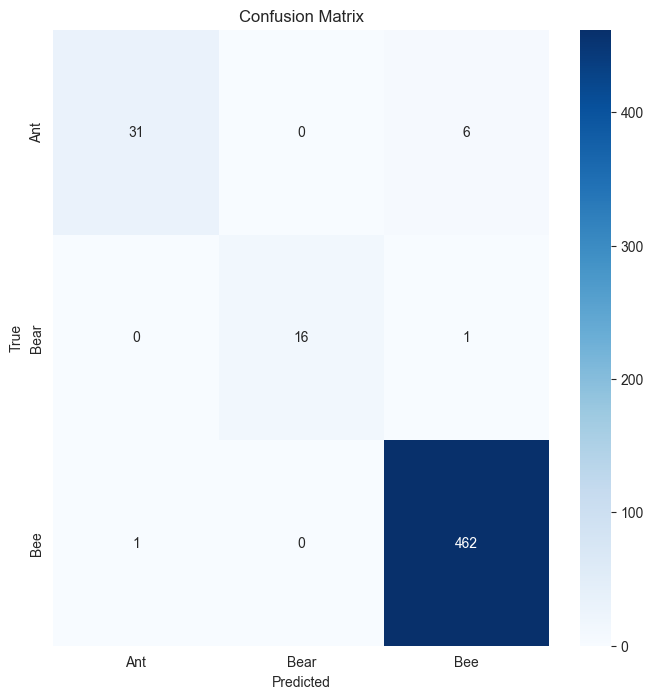

In [23]:
y_true, y_pred = predict_test_data(pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
pretrained_model.save('./models/PretrainedResNet50.keras')

## Data Augmentation

In [24]:
def visualize(original, augmented):
    fig = plt.figure(figsize=(8, 4))

    def prepare(img):
        # Ensure float32 and normalize only if needed
        if img.dtype != tf.uint8:
            img = tf.clip_by_value(img, 0, 255)
            img = tf.cast(img, tf.uint8)

        img = img.numpy()

        if img.shape[-1] == 1:
            return img.squeeze(), 'gray'
        else:
            return img, None

    orig_img, cmap1 = prepare(original)
    aug_img, cmap2 = prepare(augmented)

    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(orig_img, cmap=cmap1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(aug_img, cmap=cmap2)
    plt.axis('off')

    plt.show()

In [25]:
# random zoom tf.image.central_crop
def zoom_img(image):
    rand = random.uniform(0.5, 1.0)
    zoomed = tf.image.central_crop(image, central_fraction=rand)
    return tf.image.resize(zoomed, (224, 224))

In [26]:
# random crop tf.image.stateless_random_crop
def crop_img(image):
    random_seed = (random.randint(0, 10000), random.randint(0, 10000))
    cropped = tf.image.stateless_random_crop(image, (112, 112, 3), seed=random_seed)
    return tf.image.resize(cropped, (224, 224))

In [27]:
# random translation (color) tf.image.rgb_to_grayscale
def grey_img(image):
    return tf.image.rgb_to_grayscale(image)

In [28]:
# rotation
def translate_img(image):
    rot = tf.image.rot90(image)
    return tf.image.resize(rot, (224, 224))

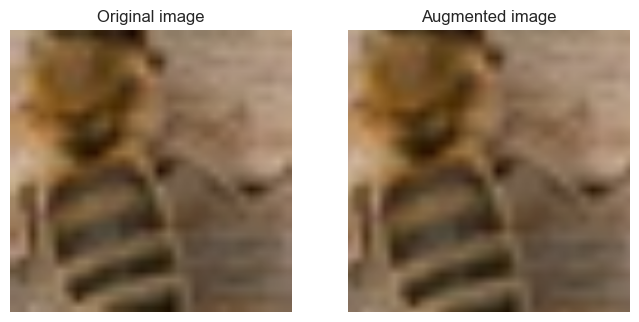

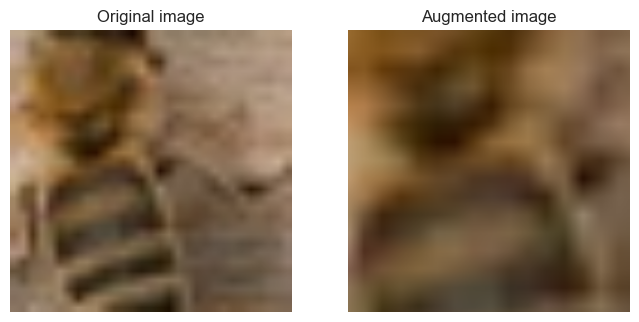

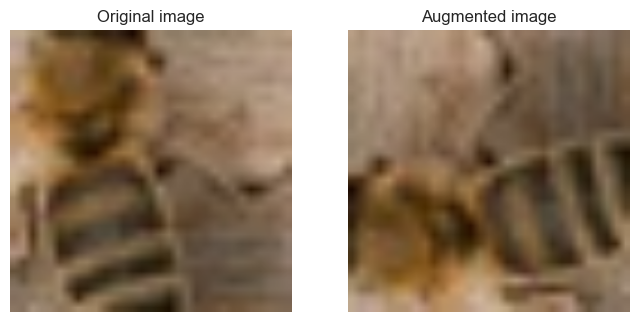

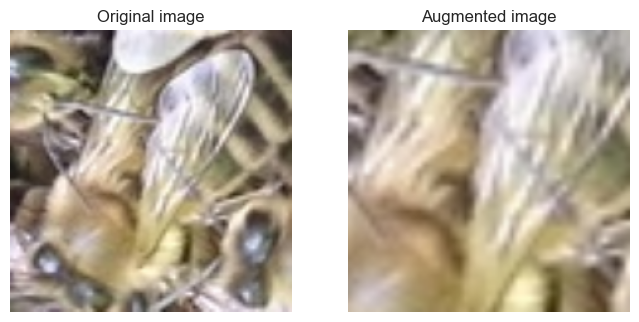

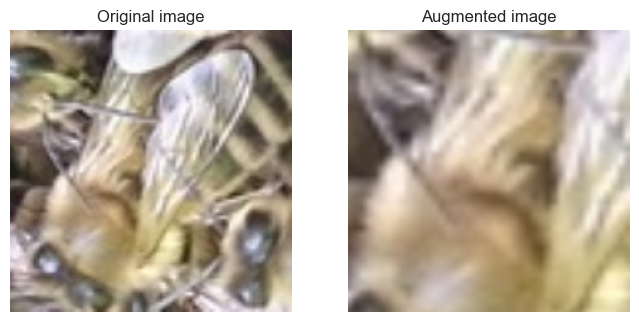

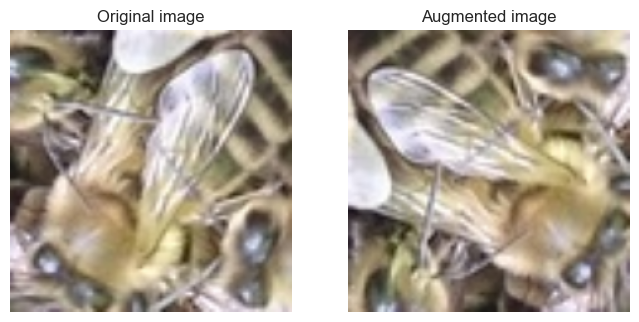

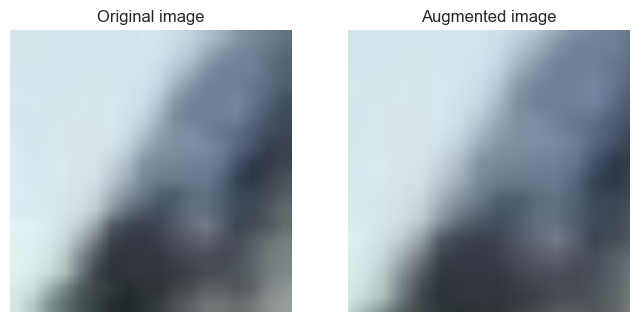

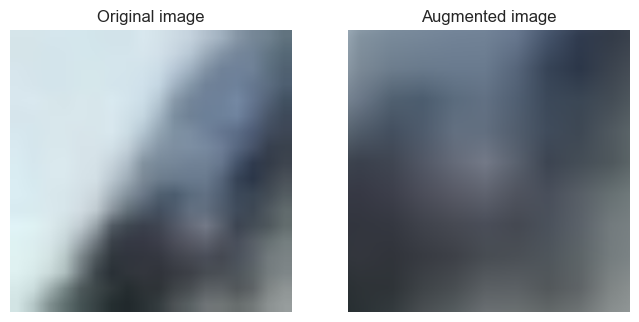

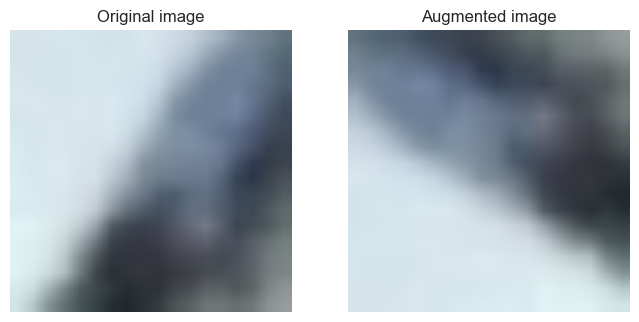

In [29]:
img_data = train_ds.unbatch()

for img, label in img_data.take(3):
    image = img
    aug_zoom = zoom_img(image)
    aug_crop = crop_img(image)
    aug_translate = translate_img(image)

    visualize(img, aug_zoom)
    visualize(img, aug_crop)
    visualize(img, aug_translate)

In [30]:
# random left-right flip tf.image.flip_left_right

In [31]:
# augment_train_data(train_ds):
def apply_augmentation(dataset, aug_fn):
    def augment(image, label):
        image = aug_fn(image)
        return image, label
    return dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [32]:
def augment_data(ds, fractions=None):
    if fractions is None:
        fractions = {'zoom': 0.3, 'crop': 0.3, 'translate': 0.3}  # remaining 0.1 will be unaugmented

    # Unbatch dataset to access individual images
    unbatched = ds.unbatch()
    images, labels = [], []

    for img, label in unbatched:
        images.append(img)
        labels.append(label)

    total = len(images)
    idxs = list(range(total))
    random.shuffle(idxs)

    zoom_n = int(fractions['zoom'] * total)
    crop_n = int(fractions['crop'] * total)
    trans_n = int(fractions['translate'] * total)
    remain_n = total - (zoom_n + crop_n + trans_n)

    # Split indices
    zoom_idxs = idxs[:zoom_n]
    crop_idxs = idxs[zoom_n:zoom_n + crop_n]
    trans_idxs = idxs[zoom_n + crop_n:zoom_n + crop_n + trans_n]
    remain_idxs = idxs[zoom_n + crop_n + trans_n:]

    # Augment
    aug_images, aug_labels = [], []
    # add augmented data to unaugmented images
    for i in zoom_idxs:
        images.append(zoom_img(images[i]))
        labels.append(labels[i])

    for i in crop_idxs:
        images.append(crop_img(images[i]))
        labels.append(labels[i])

    for i in trans_idxs:
        images.append(translate_img(images[i]))
        labels.append(labels[i])

    for i in remain_idxs:
        images.append(images[i])
        labels.append(labels[i])

    # Create new dataset
    aug_ds = tf.data.Dataset.from_tensor_slices((images, labels))
    aug_ds = aug_ds.shuffle(1000).batch(batch_size)#.prefetch(tf.data.AUTOTUNE)

    return aug_ds

In [33]:
aug_train_ds = augment_data(train_ds)

#### Base Model with data augmentation

In [34]:
aug_base_model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), classes=len(class_names)) # include_top=True adds the classification layer

aug_base_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

aug_history = aug_base_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.8229 - loss: 0.9392 - val_accuracy: 0.0626 - val_loss: 2282.9756
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.8934 - loss: 0.4410 - val_accuracy: 0.9071 - val_loss: 0.3897
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.8902 - loss: 0.3883 - val_accuracy: 0.9006 - val_loss: 0.4087
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.8915 - loss: 0.3919 - val_accuracy: 0.9093 - val_loss: 0.3826
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9004 - loss: 0.2978 - val_accuracy: 0.8877 - val_loss: 0.3572
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9186 - loss: 0.2705 - val_accuracy: 0.8834 - val_loss: 17.0215
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9072 - loss: 0.3491 - val_accuracy: 0.8121 - val_loss: 11.1045
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9003 - loss: 0.2878 - val_accuracy: 0.695

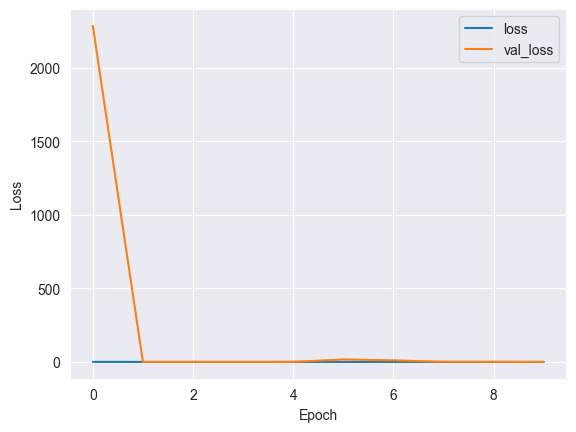

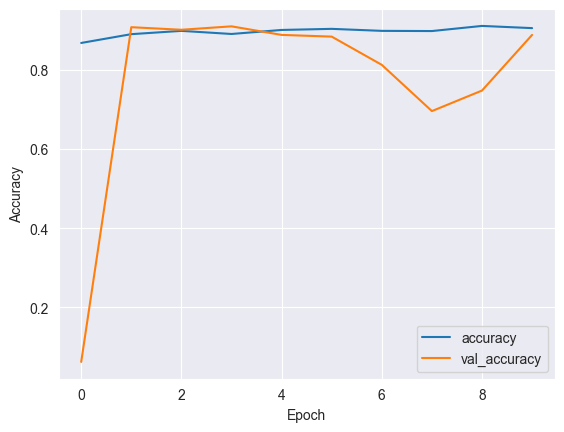

In [35]:
plot_loss(aug_history)
plot_accuracy(aug_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
              precision    recall  f1-score   support

         Ant       0.29      0.05      0.09        37
        Bear       0.30      0.18      0.22        17
         Bee       0.91      0.98      0.94       463

    accuracy                           0.89       517
   macro avg       0.50      0.40      0.42       517
weighted avg  

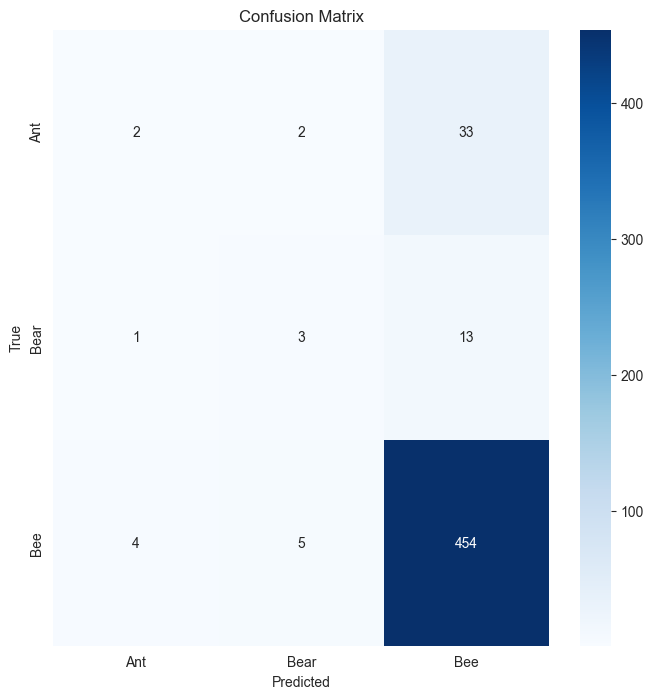

In [36]:
y_true, y_pred = predict_test_data(aug_base_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_base_model.save('./models/AugPlainResNet50.keras')

#### Pre-trained model with data augmentation

In [37]:
aug_pretrained_model = build_pretrained_model()
aug_pretrained_history = aug_pretrained_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 635ms/step - accuracy: 0.8834 - loss: 0.9611 - val_accuracy: 0.9892 - val_loss: 0.0417
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 617ms/step - accuracy: 0.9837 - loss: 0.0479 - val_accuracy: 0.9935 - val_loss: 0.0302
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 617ms/step - accuracy: 0.9927 - loss: 0.0258 - val_accuracy: 0.9914 - val_loss: 0.0320
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 616ms/step - accuracy: 0.9978 - loss: 0.0109 - val_accuracy: 0.9914 - val_loss: 0.0263
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - accuracy: 0.9989 - loss: 0.0073 - val_accuracy: 0.9914 - val_loss: 0.0274
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9914 - val_loss: 0.0274
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9914 - val_loss: 0.0260
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accu

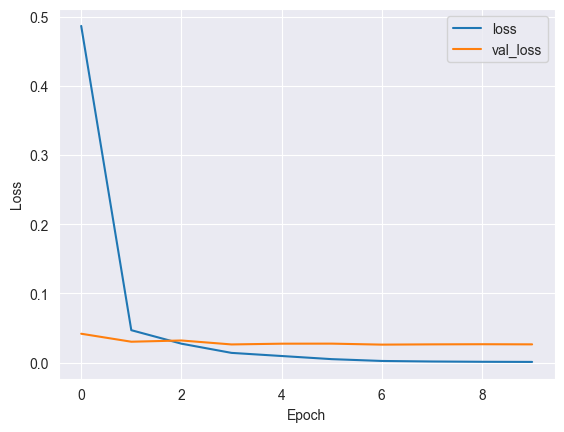

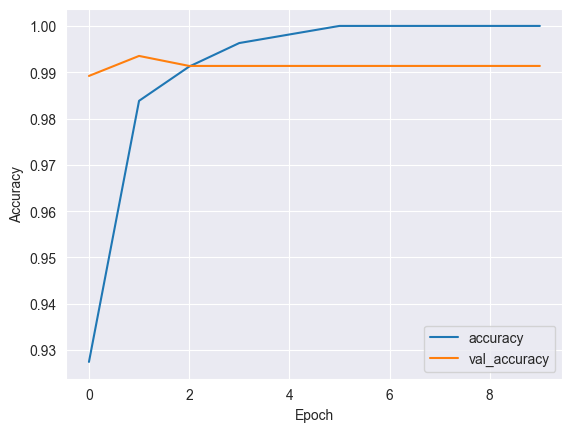

In [38]:
plot_loss(aug_pretrained_history)
plot_accuracy(aug_pretrained_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
              precision    recall  f1-score   support

         Ant       0.94      0.86      0.90        37
        Bear       0.85      1.00      0.92        17
         Bee       0.99      0.99      0.99       463

    accuracy                           0.98       517
   macro avg       0.93      0.95      0.94       517
weighted avg  

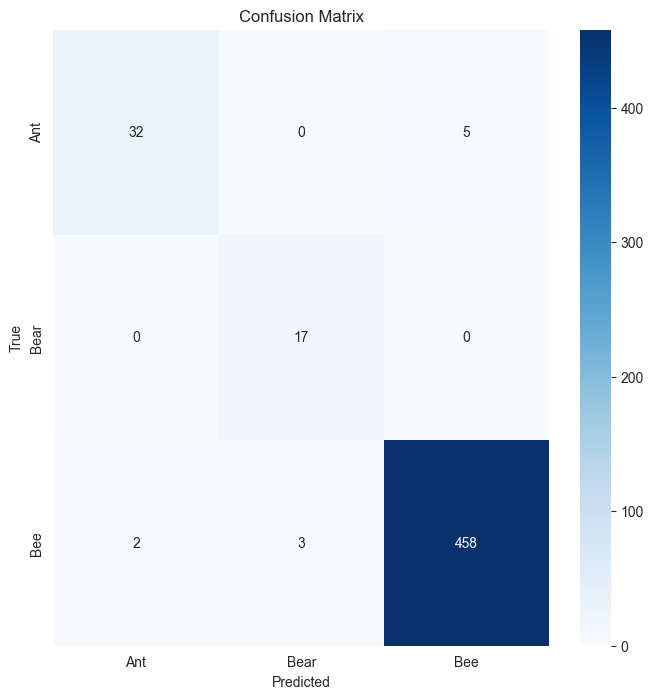

In [39]:
y_true, y_pred = predict_test_data(aug_pretrained_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)
aug_base_model.save('./models/AugPretrainedResNet50.keras')

# Custom architecture

In [10]:
def build_custom_model():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freezing conv1 layers and earlier so that they don't update (acts like a feature extractor)
    for layer in base.layers:
        if 'conv1' in layer.name:
            layer.trainable = False

    x = base.get_layer('conv3_block4_out').output

    # Inception module (process features at multiple receptive fields)
    path1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(128, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(128, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(128, (1, 1), padding='same', activation='relu')(path4)

    inception = Concatenate()([path1, path2, path3, path4])

    # Adding 1x1 convolutional layer
    x = layers.Conv2D(1024, (1, 1), padding='valid', strides=1, activation=tf.nn.leaky_relu)(inception)

    # Adding 3x3 convolutional layer
    x = layers.Conv2D(1024, (3, 3), padding='same', strides=2, activation=tf.nn.leaky_relu)(x)

    # Adding global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(3, activation='softmax')(x)

    # final model
    model = Model(inputs=base.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
custom_model = build_custom_model()
custom_model.summary()

### Custom model with original data

In [ ]:
orig_custom_history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

In [ ]:
plot_accuracy(orig_custom_history)

In [ ]:
plot_loss(orig_custom_history)

In [ ]:
y_true, y_pred = predict_test_data(custom_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)

### Custom model with data augmentation

In [ ]:
aug_custom_model = build_custom_model()

aug_custom_history = aug_custom_model.fit(
    aug_train_ds,
    validation_data=val_ds,
    epochs=10
)

In [ ]:
plot_accuracy(aug_custom_history)

In [ ]:
plot_loss(aug_custom_history)

In [ ]:
y_true, y_pred = predict_test_data(aug_custom_model, test_ds)
make_classification_report(y_true, y_pred)
make_confusion_matrix(y_true, y_pred)